### Random Forest Model Interpretation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Downloading the Libraries

In [2]:
# from fastai.imports import *
# from fastai.structured import *
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import math
import graphviz
import scipy
# import ggplot

# from pandas_summary import DataFrameSummary
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn.tree import export_graphviz
from sklearn.ensemble import forest
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.cluster import hierarchy as hc
from pdpbox import pdp
from plotnine import *
# from concurrent.futures import ProcessPoolExecutor

from sklearn import metrics

C:\Users\DELL\Anaconda3\envs\THINAM\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
def set_plot_sizes(sml, med, big):
    plt.rc('font', size=sml)
    plt.rc('axes', titlesize=sml)
    plt.rc('axes', labelsize=med)
    plt.rc('xtick', labelsize=sml)
    plt.rc('ytick', labelsize=sml)
    plt.rc('legend', fontsize=sml)
    plt.rc('figure', titlesize=big)

In [4]:
set_plot_sizes(12, 14, 16)

### Loading the Data

In [5]:
def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None, prepoc_fn=None, max_n_cat=None,
           subset=None, mapper=None):
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset:
        df = get_sample(df, subset)
    else:
        df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if prepoc_fn: prepoc_fn(df)
    if y_fld is None: y=None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)
    
    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n, c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n, c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

In [6]:
def fix_missing(df, col, name, na_dict):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict): 
            df[name + '_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

In [7]:
def numericalize(df, col, name, max_n_cat):
    if not is_numeric_dtype(col) and (max_n_cat is None or col.nunique()>max_n_cat):
        df[name] = col.cat.codes+1

In [8]:
def get_sample(df, n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

In [9]:
def set_rf_samples(n):
    forest._generate_sample_indices = (lambda rs, n_samples:
                                      forest.check_random_state(rs).randit(0, n_samples, n))

In [10]:
def reset_rf_samples():
    forest._generate_sample_indices = (lambda rs, n_samples:
                                      forest.check_random_state(rs).randit(0, n_samples, n_samples))

In [11]:
def split_vals(a, n):
    return a[:n].copy(), a[n:].copy()

In [12]:
def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

In [13]:
def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

In [14]:
def apply_cats(df, trn):
    for n, c in df.items():
        if trn[n].dtype.name == "category":
            df[n] = pd.Categorical(c, categories = trn[n].cat.categories, ordered = True )

In [15]:
def add_datepart(df, fldname, drop = True):
    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format = True)
    targ_pre = re.sub("[Dd]ate$", '', fldname)
    for n in ('Year', 'Month', 'Week', 'DayofWeek', 'DayofYear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'):
        df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elasped'] = fld.astype(np.int64) // 10**9
    if drop: df.drop(fldname, axis = 1, inplace = True)

In [16]:
def scale_vars(df, mapper):
    warnings.filterwarnings("ignore", category = sklearn.exceptions.DataConversionWarning)
    if mapper is None:
        map_f = [([n], StandardScaler()) for n in df.columns if is_numeric_dtype(df[n])]
        mapper = DataFrameMapper(map_f).fit(df)
    df[mapper.transformed_names_] = mapper.transform(df)
    return mapper

In [17]:
def rmse(x, y):
    return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train),
          rmse(m.predict(X_valid), y_valid),
          m.score(X_train, y_train),
          m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'):
        res.append(m.oob_score_)
    print(res)

In [18]:
PATH = "C:\\Users\\DELL\\Blue Book for Bulldozers\\Train.csv"

df_raw = pd.read_feather('tmp/raw')
df_trn, y_trn, nas = proc_df(df_raw, "SalePrice")

In [19]:
n_valid = 12000
n_trn = len(df_trn) - n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

raw_train, raw_valid = split_vals(df_raw, n_trn)

In [20]:
df_raw

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleWeek,saleDayofWeek,saleDayofYear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElasped
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,...,46,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,...,13,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,...,9,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,20,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,30,3,204,False,False,False,False,False,False,1248307200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,6333336,9.259131,1840702,21439,149,1.0,2005,NaN,NaN,35NX2,...,44,2,306,False,False,False,False,False,False,1320192000
401121,6333337,9.305651,1830472,21439,149,1.0,2005,NaN,NaN,35NX2,...,44,2,306,False,False,False,False,False,False,1320192000
401122,6333338,9.350102,1887659,21439,149,1.0,2005,NaN,NaN,35NX2,...,44,2,306,False,False,False,False,False,False,1320192000
401123,6333341,9.104980,1903570,21435,149,2.0,2005,NaN,NaN,30NX,...,43,1,298,False,False,False,False,False,False,1319500800


In [21]:
set_rf_samples(50000)

In [22]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1, min_samples_leaf=3, max_features=0.5, oob_score=True)
%prun m.fit(X_train, y_train)
print_score(m)

 [0.11940082913779097, 0.22652662330116619, 0.9702045800248803, 0.9083597054314816, 0.9148683105975974]


In [23]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:, 0]), np.std(preds[:, 0])

Wall time: 6.87 s


(9.203225155890106, 0.24303798760812936)

In [24]:
def parallel_trees(m, fn, n_jobs=8):
    return list(ProcessPoolExecutor(n_jobs).map(fn, m.estimators_))

In [25]:
# Repeating in Parallel
# def get_preds(t):
    # return t.predict(X_valid)
# %time preds = np.stack(parallel_trees(m, get_preds))
# np.mean(preds[:, 0]), np.std(preds[: 0])

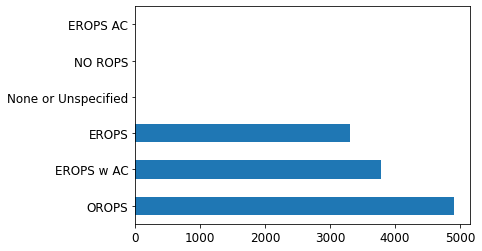

In [26]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh()

In [27]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_sum = x[flds].groupby("Enclosure", as_index=False).mean()
enc_sum

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.838054,0.243917
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.591895,0.231372
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.680719,0.201206


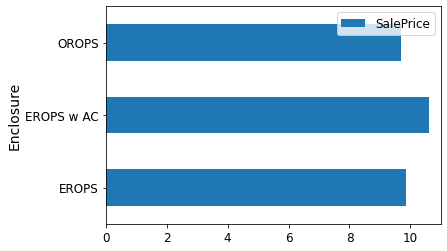

In [28]:
enc_sum = enc_sum[~pd.isnull(enc_sum.SalePrice)]
enc_sum.plot("Enclosure", "SalePrice", "barh", xlim=(0, 11))

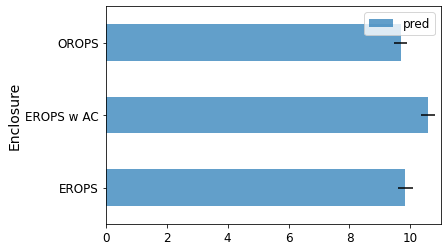

In [29]:
enc_sum.plot("Enclosure", "pred", "barh", xerr='pred_std', alpha=0.7, xlim=(0, 11))

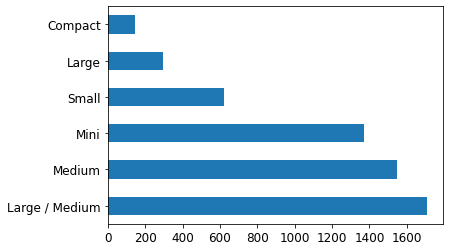

In [30]:
raw_valid.ProductSize.value_counts().plot.barh()

In [31]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby("ProductSize").mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.810065,0.298973
Large,10.470589,10.418876,0.328650
Large / Medium,10.691871,10.664308,0.262262
Medium,10.681511,10.628792,0.243286
Mini,9.535147,9.553063,0.217239
Small,10.324448,10.329760,0.284819


In [32]:
(summ.pred_std / summ.pred).sort_values(ascending=False)

ProductSize
Large             0.031544
Compact           0.030476
Small             0.027573
Large / Medium    0.024592
Medium            0.022889
Mini              0.022740
dtype: float64

### Feature Importance

In [33]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

In [34]:
fi = rf_feat_importance(m, df_trn)
fi[:10]

,cols,imp
5,YearMade,0.169218
37,Coupler_System,0.103704
13,ProductSize,0.100062
14,fiProductClassDesc,0.077009
2,ModelID,0.057381
62,saleElasped,0.053196
10,fiSecondaryDesc,0.047824
39,Hydraulics_Flow,0.045163
38,Grouser_Tracks,0.044109
8,fiModelDesc,0.035510


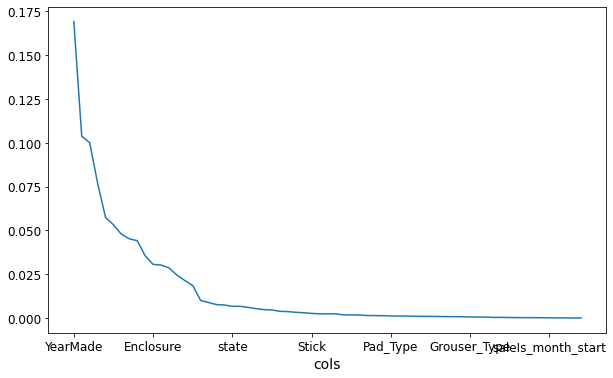

In [35]:
fi.plot('cols', 'imp', figsize=(10, 6), legend=False)

In [36]:
def plot_fi(fi):
    return fi.plot("cols", 'imp', 'barh', figsize=(12, 7), legend=False)

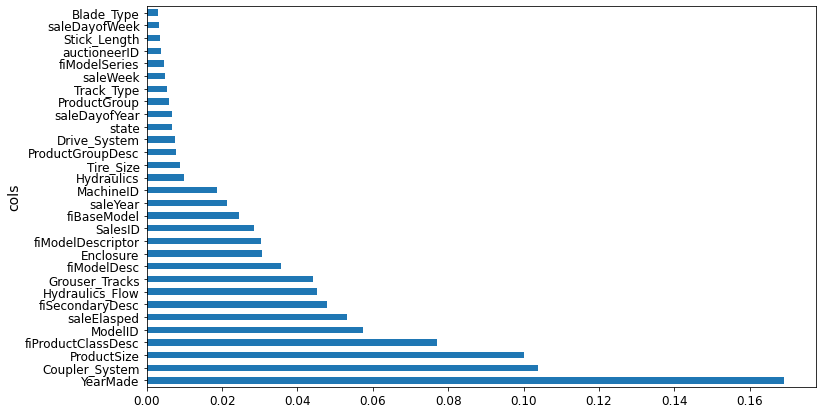

In [37]:
plot_fi(fi[:30])

In [38]:
to_keep = fi[fi.imp > 0.005].cols
len(to_keep)

24

In [39]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [40]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1, min_samples_leaf=3, max_features = 0.5, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12512721161566231, 0.22384700581358255, 0.9672781115748594, 0.9105149359621725, 0.9126506463025792]


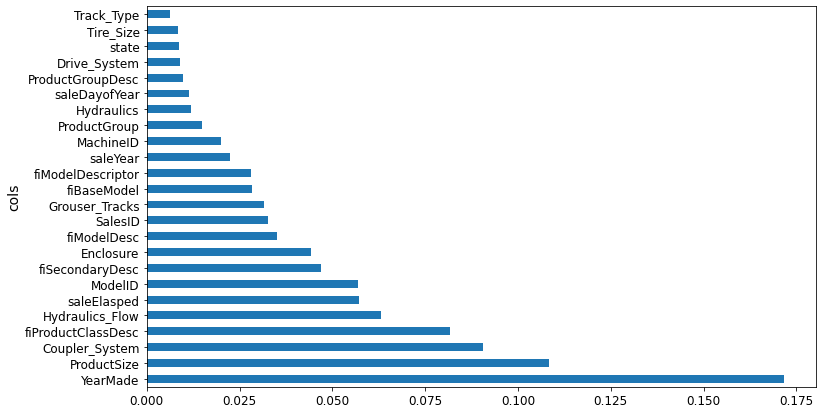

In [41]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi)

### One hot Encoding

In [42]:
df_trn2, y_trn, nas = proc_df(df_raw, "SalePrice", max_n_cat = 7)
X_train, X_valid = split_vals(df_trn2, n_trn)

In [43]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1, min_samples_leaf=3, max_features=0.5, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11994091662275477, 0.23283502643240175, 0.9699344222974442, 0.9031845649014052, 0.9134155321582519]


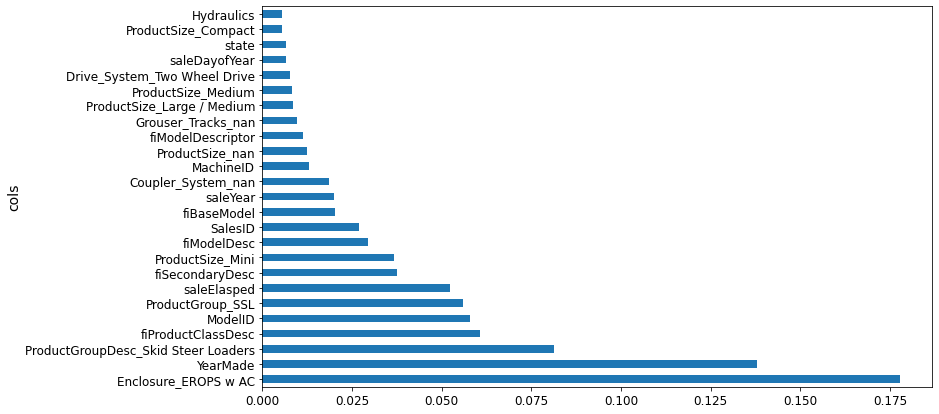

In [44]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25])

In [45]:
# Changing Categorical into Integers
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

In [46]:
df_raw.UsageBand = df_raw.UsageBand.cat.codes

### Removing Redundant Features

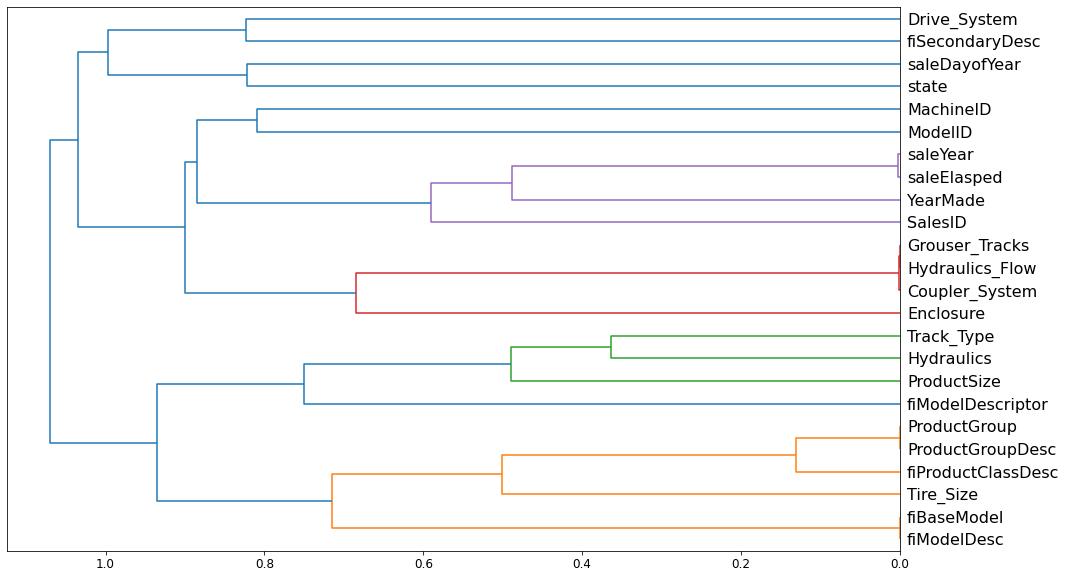

In [47]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1 - corr)
z = hc.linkage(corr_condensed, method="average")
fig = plt.figure(figsize=(16, 10))
dendrogram = hc.dendrogram(z, labels = list(df_keep.columns), orientation = "left", leaf_font_size=16)
plt.show()

In [48]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=5, max_features=0.5, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [49]:
get_oob(df_keep)

0.9084191802885345

In [50]:
df = df_keep.copy()

In [51]:
for c in ('saleYear', 'saleElasped', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df.drop(c, axis=1)))

saleYear 0.9078179457340065
saleElasped 0.905462037235043
fiModelDesc 0.9071523418487908
fiBaseModel 0.9077863476064401
Grouser_Tracks 0.9081245463640232
Coupler_System 0.908372775265809


In [52]:
df1 = df_keep.copy()
to_drop = ['saleYear', 'fiModelDesc', 'Grouser_Tracks']
get_oob(df1.drop(to_drop, axis=1))

0.9066326024663262

In [53]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [54]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [55]:
keep_cols = np.load('tmp/keep_cols.npy', allow_pickle=True)
df_keep = df_trn[keep_cols]

In [56]:
reset_rf_samples()

In [57]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1, min_samples_leaf=3, max_features=0.5, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12726921410412217, 0.22674372897851797, 0.9661482168071358, 0.9081839630659047, 0.9111292831298912]


### Partial Dependence

In [58]:
set_rf_samples(50000)

In [59]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=80, n_jobs=-1, min_samples_leaf=3, max_features=0.6)
m.fit(X_train, y_train)
# print_score(m)

RandomForestRegressor(max_features=0.6, min_samples_leaf=3, n_estimators=80,
                      n_jobs=-1)

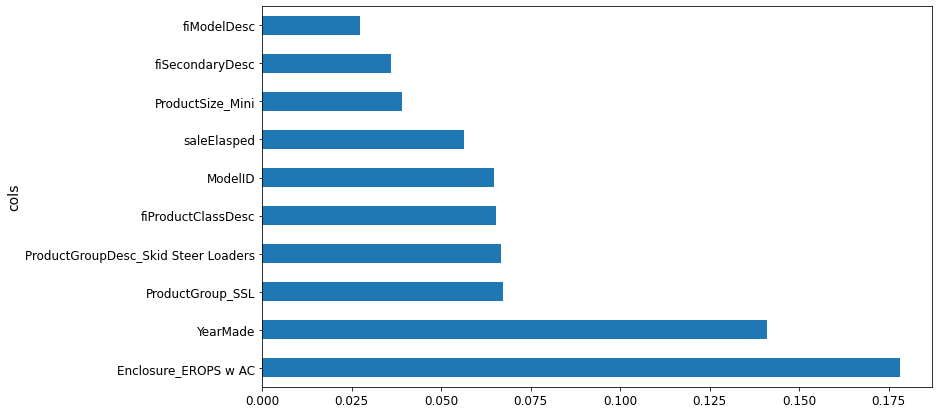

In [60]:
plot_fi(rf_feat_importance(m, df_trn2)[:10])

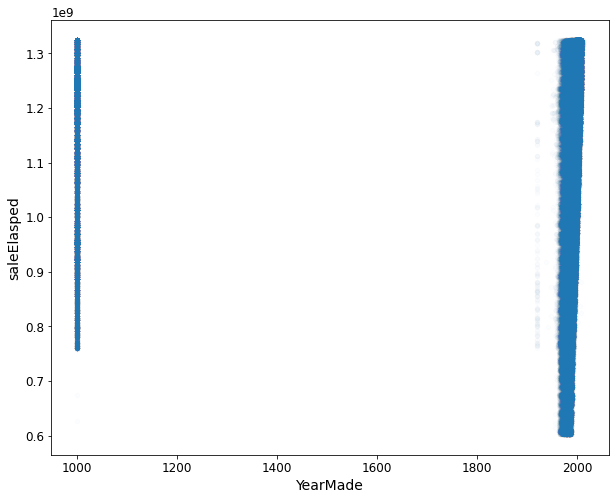

In [61]:
df_raw.plot("YearMade", "saleElasped", "scatter", alpha=0.01, figsize=(10,8))

In [62]:
x_all = get_sample(df_raw[df_raw.YearMade > 1930], 500)
# ggplot(x_all, aes('YearMade', 'SalePrice')) + stat_smooth(se=True, method="loess")

In [63]:
x = get_sample(X_train[X_train.YearMade > 1930], 500)

In [64]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feature=feat, model_features=x.columns)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                       cluster = clusters is not None,
                       n_cluster_centers = clusters)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x25400b51d08>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x25400e2e408>})

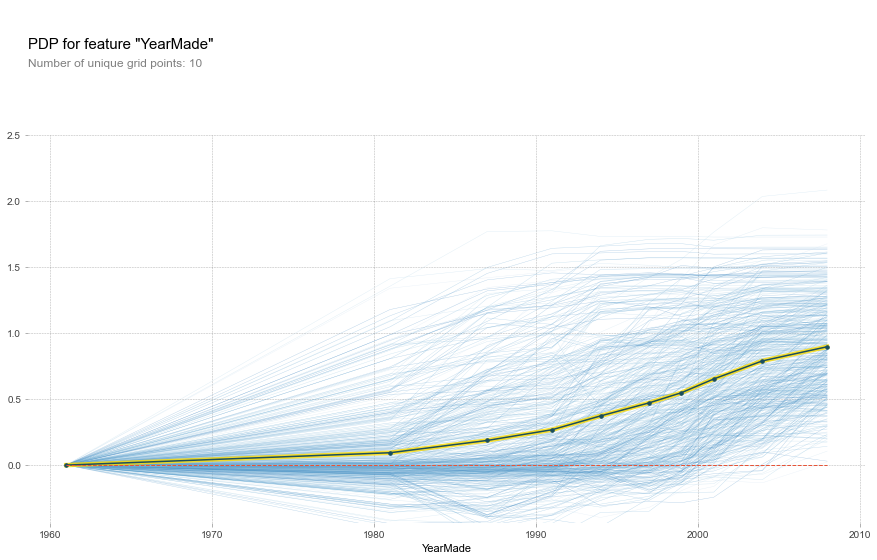

In [65]:
plot_pdp('YearMade')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x254038b2888>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x25403884c88>})

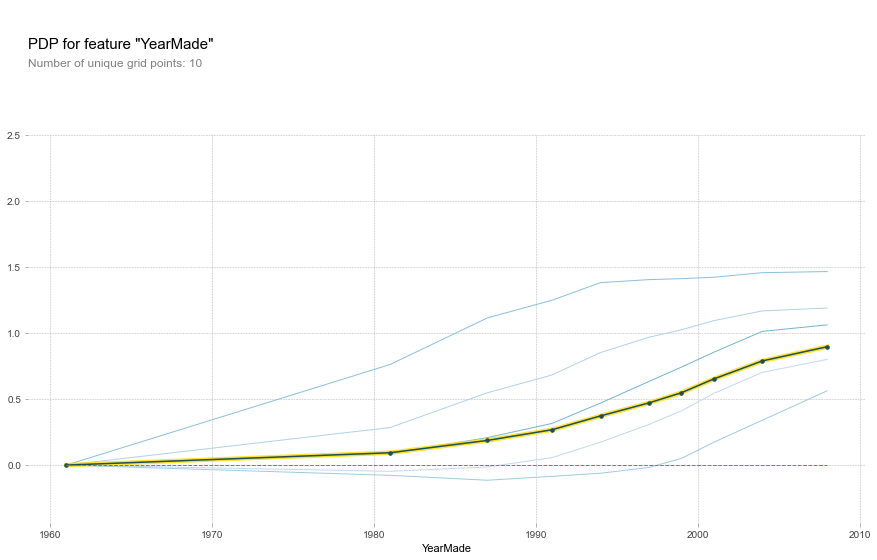

In [66]:
plot_pdp('YearMade', clusters=5)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x25403ece808>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x25403ea6688>})

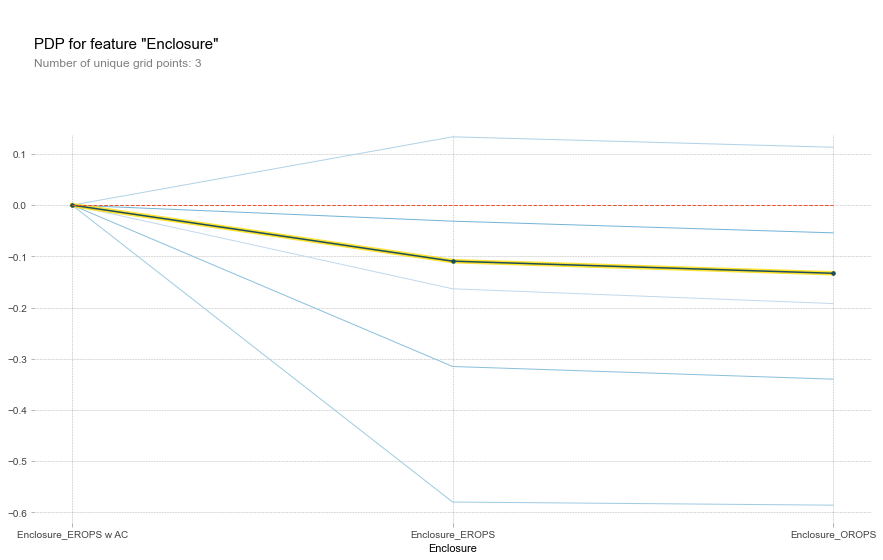

In [67]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

In [68]:
df_raw.YearMade[df_raw.YearMade < 1950] = 1950
df_keep["age"] = df_raw["age"] = df_raw.saleYear - df_raw.YearMade

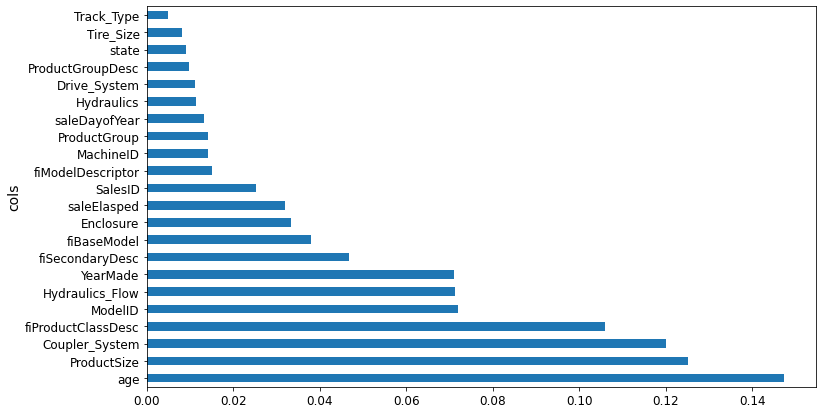

In [69]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=80, n_jobs=-1, min_samples_leaf=3, max_features=0.6)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep))

### Tree Interpreter

In [70]:
from treeinterpreter import treeinterpreter as ti

In [71]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [72]:
row = X_valid.values[None, 0].reshape((1, 22)) 
row

array([[      1999,          0,          5,         17,        665,
        1284595200,          0,          0,          1,          0,
           4364751,       1111,    2300944,         12,          0,
                 4,          0,         35,        259,          4,
                 2,         11]], dtype=int64)

In [73]:
prediction, bias, contributions = ti.predict(m, row)

In [74]:
prediction[0], bias[0]

(array([9.21873826]), 10.105639180771316)

In [75]:
idxs = np.argsort(contributions[0])

In [76]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.5933451623741474),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.20598351781600033),
 ('age', 11, -0.16267955787174632),
 ('fiBaseModel', 'KX121', -0.08188877258622233),
 ('fiSecondaryDesc', nan, -0.06929734689385074),
 ('Enclosure', 'EROPS', -0.02517957748453923),
 ('fiModelDescriptor', nan, -0.01585890093394664),
 ('saleDayofYear', 259, -0.014792206447883326),
 ('Tire_Size', nan, -0.007849854222882802),
 ('MachineID', 2300944, -0.0033447617773515238),
 ('state', 'Ohio', -0.0005099227997321654),
 ('SalesID', 4364751, 0.00042230383443584427),
 ('ProductGroupDesc', 'Track Excavators', 0.005445828753644366),
 ('Hydraulics', 'Standard', 0.0069991301547926545),
 ('Drive_System', nan, 0.008145865523634766),
 ('saleElasped', 1284595200, 0.011907874695333743),
 ('ProductGroup', 'TEX', 0.014296355281271666),
 ('Track_Type', 'Steel', 0.024398255346911136),
 ('Hydraulics_Flow', nan, 0.03287632847226647),
 ('Coupler_System', nan,

In [77]:
contributions[0].sum()

-0.8869009205685954

### Extrapolation

In [78]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [79]:
m = RandomForestClassifier(n_estimators=80, n_jobs=-1, min_samples_leaf=3, max_features=0.6, oob_score=True)
m.fit(x, y)
m.oob_score_

0.9999950140230601

In [80]:
fi = rf_feat_importance(m, x)
fi[:10]

,cols,imp
10,SalesID,0.813948
5,saleElasped,0.146734
12,MachineID,0.034435
0,YearMade,0.001293
8,Enclosure,0.000785
18,saleDayofYear,0.000776
11,fiBaseModel,0.000636
4,ModelID,0.000618
1,Coupler_System,0.000273
21,age,0.000216


In [81]:
feats = ['SalesID', 'saleElasped', 'MachineID']

In [82]:
(X_train[feats]/1000).describe()

,SalesID,saleElasped,MachineID
count,389125.000000,3.891250e+05,389125.000000
mean,1800.452485,1.084797e+06,1206.796148
std,595.627288,1.803913e+05,430.850552
min,1139.246000,6.009984e+05,0.000000
25%,1413.348000,9.666432e+05,1087.016000
50%,1632.093000,1.134605e+06,1273.859000
75%,2210.453000,1.234138e+06,1458.661000
max,4364.741000,1.325117e+06,2313.821000


In [83]:
(X_valid[feats]/1000).describe()

,SalesID,saleElasped,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+06,1578.049709
std,836.899608,2.497808e+04,589.497173
min,4364.751000,1.174522e+06,0.830000
25%,4408.580750,1.309219e+06,1271.225250
50%,6272.538500,1.316045e+06,1825.317000
75%,6291.792250,1.321402e+06,1907.858000
max,6333.342000,1.325203e+06,2486.330000


In [84]:
x.drop(feats, axis=1, inplace=True)

In [85]:
m = RandomForestClassifier(n_estimators=80, n_jobs=-1, min_samples_leaf=3, max_features=0.6, oob_score=True)
m.fit(x, y)
m.oob_score_

0.982020567154877

In [86]:
fi = rf_feat_importance(m, x)
fi[:10]

,cols,imp
18,age,0.246607
0,YearMade,0.202086
15,saleDayofYear,0.183550
4,ModelID,0.071972
14,state,0.057906
9,fiBaseModel,0.054385
7,Enclosure,0.030891
3,fiProductClassDesc,0.029571
10,Hydraulics,0.023833
5,fiSecondaryDesc,0.021743


In [87]:
set_rf_samples(50000)

In [93]:
feats = ['SalesID', 'saleElasped', 'MachineID', 'age', 'YearMade', 'saleDayofYear']

In [89]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=3, max_features=0.6, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12479572843842338, 0.2254212125767826, 0.9674512535789725, 0.909251900788409, 0.9084031598979005]


In [90]:
df = df_keep.copy()

In [94]:
for f in feats:
    df_subs = df.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=3, max_features=0.6, oob_score = True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.12883787659082557, 0.22391182743173346, 0.9653085906889912, 0.9104631022868079, 0.9083732578643887]
saleElasped
[0.13068369134794078, 0.23263559488010832, 0.9643074470408248, 0.9033503456585671, 0.9035832063967832]
MachineID
[0.1286899437532318, 0.2245315743760185, 0.9653882109443255, 0.9099667728809071, 0.909698699858922]
age
[0.12528616804823475, 0.2272000332770075, 0.9671949217015016, 0.9078140458134878, 0.9091324745868375]
YearMade
[0.1258590795089016, 0.22873751697138112, 0.9668942120962443, 0.9065621624904107, 0.9081053774179346]
saleDayofYear
[0.12917141616415534, 0.22637048696751827, 0.9651287377482665, 0.9084859903536183, 0.9075641079163886]


In [95]:
df = df_keep.copy()

In [96]:
df_subs = df.drop(['SalesID', 'MachineID', 'saleDayofYear'], axis=1)

In [97]:
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=80, n_jobs=-1, min_samples_leaf=3, max_features=0.6, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1405552385110159, 0.21693409094794772, 0.9587115196192101, 0.9159566052402288, 0.9112541473746065]


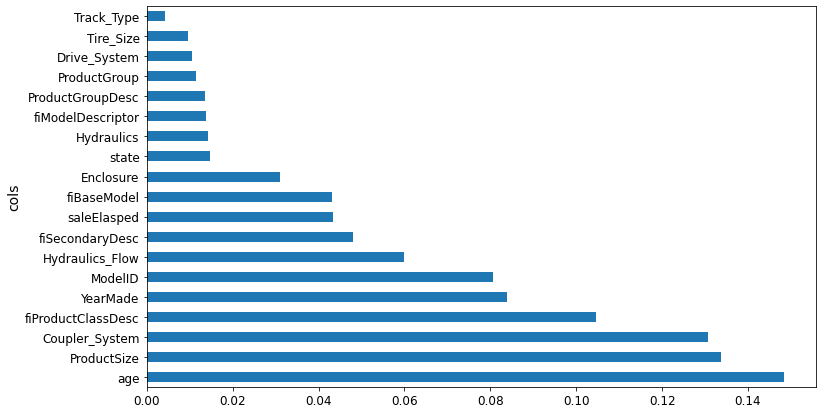

In [98]:
plot_fi(rf_feat_importance(m, X_train))

In [99]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

### Final Model

In [100]:
m = RandomForestRegressor(n_estimators=160, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 1min 29s
[0.1441388211444497, 0.21767769154052669, 0.9565793062861454, 0.9153794545794618, 0.9118437897583609]
